# 03 - Predictability & Universe Filtering

1. Compute rolling predictability metrics for each ticker
2. Visualize and compare scores across universe and time
3. Select top-N most “learnable” tickers for RL agent
4. Document all decisions, assumptions, and open questions


In [1]:
# SETUP: Imports & Paths ===========================
import jupyter

import os
import pandas as pd


from tqdm import tqdm
from src.data.feature_pipeline import basic_chart_features,load_base_dataframe
from src.predictability.easiness import rolling_sharpe, rolling_r2, rolling_info_ratio, rolling_autocorr
from src.predictability.pipeline import generate_universe_easiness_report
from IPython import display
from src.utils.system import boot,notify
from src.experiments.experiment_tracker import ExperimentTracker

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
features = [
        'store_nbr', 'family', 'dayofweek', 'month', 'day', 'week', 'is_holiday',
        'transactions', 'lag_7', 'lag_14', 'trans_lag_7', 'trans_lag_14',
        'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14',
        'trans_roll_mean_7', 'trans_roll_mean_14',
        'onpromo_lag_7', 'onpromo_mean_14'
]

run_settings={
    "n_estimators":1000, 
    "learning_rate":0.05, 
    "max_depth":6, 
    "random_state":42,
    "regime": "rolling_mean",
    "features": features.copy()
}
run_settings["features"].sort()
run_settings

{'n_estimators': 1000,
 'learning_rate': 0.05,
 'max_depth': 6,
 'random_state': 42,
 'regime': 'rolling_mean',
 'features': ['day',
  'dayofweek',
  'family',
  'is_holiday',
  'lag_14',
  'lag_7',
  'month',
  'onpromo_lag_7',
  'onpromo_mean_14',
  'rolling_mean_14',
  'rolling_mean_7',
  'rolling_std_14',
  'rolling_std_7',
  'store_nbr',
  'trans_lag_14',
  'trans_lag_7',
  'trans_roll_mean_14',
  'trans_roll_mean_7',
  'transactions',
  'week']}

In [3]:
boot()
notify('03 - Predictability & Universe Filtering',title="Train complete", level="info")

In [8]:
# LOAD OHLCV ==========================================
ohlcv_df = load_base_dataframe()
ohlcv_df.tail()
_ohlcv=ohlcv_df.copy()
ohlcv_df.to_csv('ohlcv.csv')

In [7]:
# CROP THE SAMPLE =======================================
tickers = ohlcv_df['symbol'].unique()

## How to intrepret
| Metric                             | Good Sign                  | Bad Sign                            |
| ---------------------------------- | -------------------------- | ----------------------------------- |
| R² > 0.3                           | Model captures real signal | R² ≈ 0: model is guessing           |
| MAE low (e.g., < 0.05)             | Close predictions          | MAE > 0.1 is noisy                  |
| Scatter points cluster on diagonal | High correlation           | Wide dispersion = model uncertainty |


In [156]:
notify('teste')

In [157]:
result_df.describe()

,true_r2,predicted_r2
count,18.000000,18.000000
mean,0.023697,0.048580
std,0.027648,0.024395
min,0.000226,0.015993
25%,0.003473,0.028728
50%,0.009950,0.044306
75%,0.045028,0.065263
max,0.098219,0.096468


In [158]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import skew, kurtosis, entropy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from IPython.display import display

warnings.filterwarnings("ignore")

# === Simulate a realistic dataset ===
np.random.seed(42)
#dates = pd.date_range(start="2022-01-01", end="2024-12-31", freq="D")
dates = pd.date_range(start="2022-01-01", end="2022-06-01", freq="D")
symbols = ['AAPL', 'GOOG', 'MSFT' ]
data = []

for symbol in tqdm(symbols):
    print('Round 1',symbol)
    #trend = np.linspace(100, 200, len(dates)) + np.random.normal(0, 5, len(dates))
    for i, date in enumerate(dates):
        ret = np.random.randn() * 0.01

        data.append({
            'date': date,
            'symbol': symbol,
            'close': ohlcv_df[ohlcv_df['symbol']==symbol]['close'].values,#np.random.rand() * 100 + 100,
            'return_1d': ohlcv_df[ohlcv_df['symbol']==symbol]['return_1d'].values,
            'volume': ohlcv_df[ohlcv_df['symbol']==symbol]['volume'].values#np.random.randint(1e5, 1e6)
        })

df = pd.DataFrame(data)
df['month'] = df['date'].dt.to_period('M')
df['return_1d'] = df['return_1d'].fillna(0)

# === Extract enriched features and labels ===
feature_rows = []
label_rows = []
def flatten_cell(x):
    if isinstance(x, (list, np.ndarray)):
        return float(x[0]) if len(x) > 0 else np.nan
    return float(x)



for symbol in tqdm(symbols):
    print('Round 2',symbol)
    symbol_data = df[df['symbol'] == symbol].sort_values('date')
    grouped = symbol_data.groupby('month')

    months = list(grouped.groups.keys())
    for i in range(len(months) - 1):
        m_t = months[i]
        m_t1 = months[i + 1]

        df_t = grouped.get_group(m_t)
        df_t1 = grouped.get_group(m_t1)

        if len(df_t1) < 10:
            continue
        def flatten_cell(x):
            if isinstance(x, (list, np.ndarray)):
                return float(x[0]) if len(x) > 0 else np.nan
            return float(x)

        r1d = df_t['return_1d'].apply(flatten_cell)
        v = df_t['volume'].apply(flatten_cell)

        # === Features from T ===
        # Ensure return_1d is flat and numeric
        returns = df_t['return_1d'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x).astype(np.float64).values

        features = {
            'symbol': symbol,
            'month': str(m_t),
            'mean_return': returns.mean(),
            'std_return': returns.std(),
            'skew_return': skew(returns),
            'kurtosis_return': kurtosis(returns),
            'entropy_return': entropy(np.histogram(returns, bins=10, density=True)[0] + 1e-8),
            'volume_mean': v.mean(),#df_t['volume'].mean(),
            'volume_std': v.std() #df_t['volume'].std()
        }


        # === Label from T+1 ===
        y = df_t1['return_1d'].values
        X_dummy = np.arange(len(y)).reshape(-1, 1)
        base_model = LinearRegression().fit(X_dummy, y)
        r2 = base_model.score(X_dummy, y)

        label = int(r2 > 0.1)  # Predictable if R² > 0.1

        feature_rows.append(features)
        label_rows.append(label)

# === Build dataset ===
X_df = pd.DataFrame(feature_rows)
y_df = pd.Series(label_rows, name='is_predictable')

metadata = X_df[['symbol', 'month']]
X = X_df.drop(['symbol', 'month'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train classifier ===
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_scaled, y_df, metadata, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# === Report and confusion matrix ===
report = classification_report(y_test, y_pred, output_dict=True)
conf_mat = confusion_matrix(y_test, y_pred)

# === Create full report DataFrame ===
report_df = pd.DataFrame(report).transpose()
report_df['support'] = report_df['support'].astype(int)

# === Identify top-k easiest stocks (predicted = 1) ===
predictions_df = meta_test.copy()
predictions_df['predicted_label'] = y_pred
predictions_df['true_label'] = y_test.values
top_predictable = predictions_df[predictions_df['predicted_label'] == 1]

print("Top Predictable Stock-Months:")
display(top_predictable.head(10))

# === Plot confusion matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Predictable', 'Predictable'], yticklabels=['Not Predictable', 'Predictable'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Display classification report
print("\nClassification Report:")
display(report_df.round(3))


  0%|          | 0/3 [00:00<?, ?it/s]

Round 1 AAPL


  0%|          | 0/3 [00:10<?, ?it/s]

KeyboardInterrupt



In [165]:
symbols = ohlcv_df['symbol'].unique()#"[:10] #['AAPL', 'GOOG']
skip_symobol
symbols

['CEGGEHC', 'GEV', 'CEG']

100%|██████████| 500/500 [00:38<00:00, 12.89it/s]



==== Strategy: R2 ====
Top Predictable Stock-Months:


,symbol,month,predicted_label,true_label
4,MMM,2022-05-01,1,0
6,MMM,2022-07-01,1,1
7,MMM,2022-08-01,1,0
9,MMM,2022-10-01,1,0
15,AOS,2022-05-01,1,0
17,AOS,2022-07-01,1,1
18,AOS,2022-08-01,1,0
19,AOS,2022-09-01,1,0
20,AOS,2022-10-01,1,0
21,AOS,2022-11-01,1,0


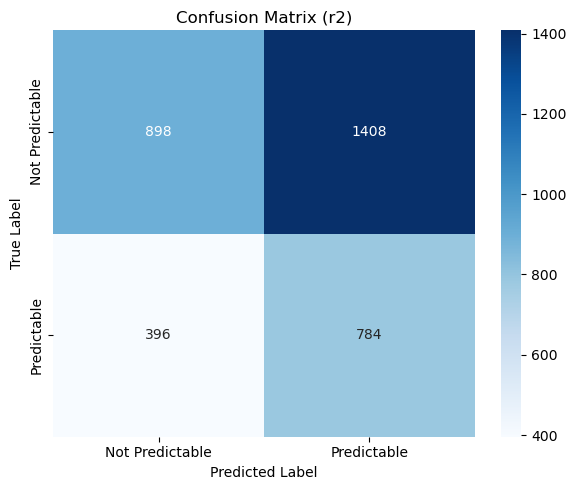


Classification Report:


,precision,recall,f1-score,support
0,0.694,0.389,0.499,2306
1,0.358,0.664,0.465,1180
accuracy,0.483,0.483,0.483,0
macro avg,0.526,0.527,0.482,3486
weighted avg,0.580,0.483,0.487,3486


100%|██████████| 500/500 [00:39<00:00, 12.72it/s]



==== Strategy: DIRECTIONAL_ACCURACY ====
Top Predictable Stock-Months:


,symbol,month,predicted_label,true_label
4,MMM,2022-05-01,1,1
5,MMM,2022-06-01,1,1
6,MMM,2022-07-01,1,1
7,MMM,2022-08-01,1,1
8,MMM,2022-09-01,1,1
9,MMM,2022-10-01,1,0
10,MMM,2022-11-01,1,0
15,AOS,2022-05-01,1,1
16,AOS,2022-06-01,1,0
17,AOS,2022-07-01,1,0


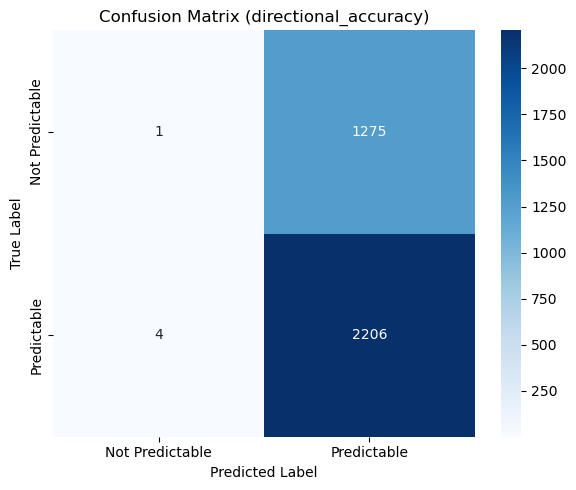


Classification Report:


,precision,recall,f1-score,support
0,0.200,0.001,0.002,1276
1,0.634,0.998,0.775,2210
accuracy,0.633,0.633,0.633,0
macro avg,0.417,0.499,0.388,3486
weighted avg,0.475,0.633,0.492,3486


100%|██████████| 500/500 [00:38<00:00, 12.83it/s]



==== Strategy: ENTROPY ====
Top Predictable Stock-Months:


,symbol,month,predicted_label,true_label
29,ABT,2022-08-01,1,0
82,AES,2022-06-01,1,0
258,AMCR,2022-06-01,1,0
877,CDNS,2022-09-01,1,0
983,CBOE,2022-05-01,1,0
1308,COP,2022-11-01,1,1
1710,DUK,2022-06-01,1,0
2240,FCX,2022-08-01,1,0
3085,LVS,2022-06-01,1,0
3362,MDT,2022-08-01,1,1


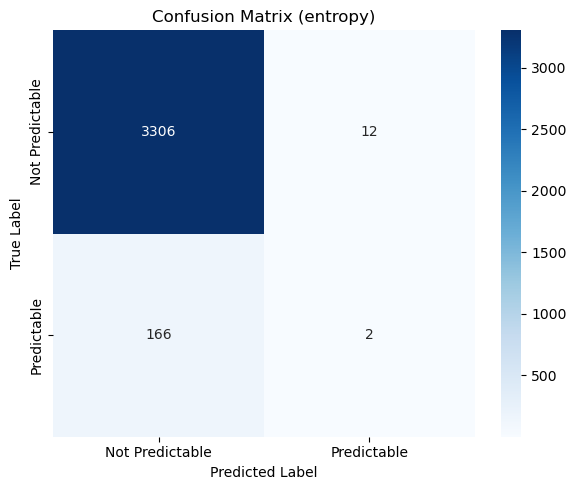


Classification Report:


,precision,recall,f1-score,support
0,0.952,0.996,0.974,3318
1,0.143,0.012,0.022,168
accuracy,0.949,0.949,0.949,0
macro avg,0.548,0.504,0.498,3486
weighted avg,0.913,0.949,0.928,3486


100%|██████████| 500/500 [00:41<00:00, 12.03it/s]



==== Strategy: FORECAST_STABILITY ====
Top Predictable Stock-Months:


,symbol,month,predicted_label,true_label
4,MMM,2022-05-01,1,1
5,MMM,2022-06-01,1,1
6,MMM,2022-07-01,1,0
7,MMM,2022-08-01,1,1
8,MMM,2022-09-01,1,1
9,MMM,2022-10-01,1,1
10,MMM,2022-11-01,1,1
15,AOS,2022-05-01,1,1
16,AOS,2022-06-01,1,1
17,AOS,2022-07-01,1,1


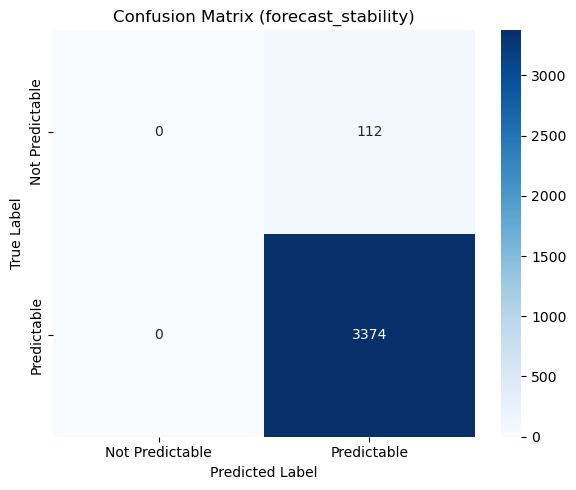


Classification Report:


,precision,recall,f1-score,support
0,0.000,0.000,0.000,112
1,0.968,1.000,0.984,3374
accuracy,0.968,0.968,0.968,0
macro avg,0.484,0.500,0.492,3486
weighted avg,0.937,0.968,0.952,3486


100%|██████████| 500/500 [00:47<00:00, 10.43it/s]



==== Strategy: ENSEMBLE ====
Top Predictable Stock-Months:


,symbol,month,predicted_label,true_label
4,MMM,2022-05-01,1,1
5,MMM,2022-06-01,1,1
6,MMM,2022-07-01,1,1
7,MMM,2022-08-01,1,1
8,MMM,2022-09-01,1,1
9,MMM,2022-10-01,1,0
10,MMM,2022-11-01,1,0
15,AOS,2022-05-01,1,1
16,AOS,2022-06-01,1,0
17,AOS,2022-07-01,1,1


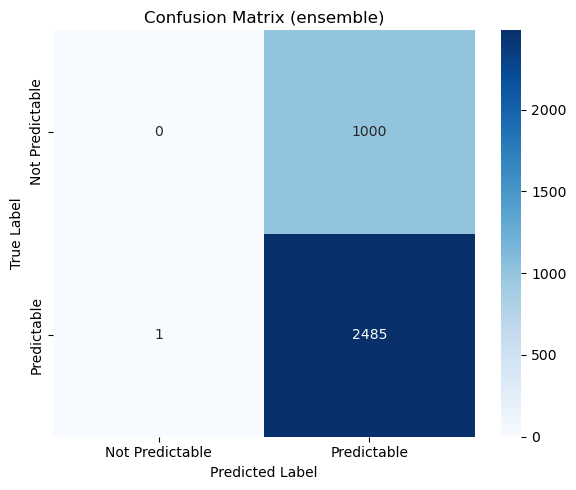


Classification Report:


,precision,recall,f1-score,support
0,0.000,0.000,0.000,1000
1,0.713,1.000,0.832,2486
accuracy,0.713,0.713,0.713,0
macro avg,0.357,0.500,0.416,3486
weighted avg,0.509,0.713,0.594,3486


In [187]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import skew, kurtosis, entropy as shannon_entropy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display
import warnings

warnings.filterwarnings("ignore")

skip_symbols = ['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV']

# Labeling thresholds
thresholds = {
    'r2': 0.05,
    'directional_accuracy': 0.6,
    'entropy': 0.55,
    'forecast_stability': 0.01
}

# Filter the data
filtered_df = ohlcv_df[(ohlcv_df['date'] >= "2022-01-01") & (ohlcv_df['date'] < "2023-01-01")].copy()
filtered_df['month'] = filtered_df['date'].dt.to_period('M')
filtered_df['return_1d'] = filtered_df['return_1d'].fillna(0)

label_strategies = list(thresholds.keys()) + ['ensemble']
results_by_strategy = {}

for strategy in label_strategies:
    feature_rows, label_rows = [], []

    for symbol in tqdm(filtered_df['symbol'].unique()):
        if symbol in skip_symbols:
            continue

        symbol_data = filtered_df[filtered_df['symbol'] == symbol].sort_values('date')
        grouped = symbol_data.groupby('month')
        months = list(grouped.groups.keys())

        for i in range(len(months) - 1):
            m_t, m_t1 = months[i], months[i + 1]
            df_t, df_t1 = grouped.get_group(m_t), grouped.get_group(m_t1)
            if len(df_t1) < 10:
                continue

            r1d = df_t['return_1d'].astype(float).values
            v = df_t['volume'].astype(float).values

            features = {
                'symbol': symbol,
                'month': str(m_t),
                'mean_return': r1d.mean(),
                'std_return': r1d.std(),
                'skew_return': skew(r1d),
                'kurtosis_return': kurtosis(r1d),
                'entropy_return': shannon_entropy(np.histogram(r1d, bins=10, density=True)[0] + 1e-8),
                'volume_mean': v.mean(),
                'volume_std': v.std()
            }

            # Labeling logic
            y = df_t1['return_1d'].astype(float).values
            X_dummy = np.arange(len(y)).reshape(-1, 1)

            r2_model = LinearRegression().fit(X_dummy, y)
            r2_score = r2_model.score(X_dummy, y)

            y_direction = (y > 0).astype(int)
            log_model = LogisticRegression().fit(X_dummy, y_direction)
            acc_score = (log_model.predict(X_dummy) == y_direction).mean()
            probas = log_model.predict_proba(X_dummy)
            ent_score = np.mean([shannon_entropy(p) for p in probas])
            pred_std = np.std(r2_model.predict(X_dummy))

            label = 0
            if strategy == 'r2':
                label = int(r2_score > thresholds['r2'])
            elif strategy == 'directional_accuracy':
                label = int(acc_score > thresholds['directional_accuracy'])
            elif strategy == 'entropy':
                label = int(ent_score < thresholds['entropy'])
            elif strategy == 'forecast_stability':
                label = int(pred_std < thresholds['forecast_stability'])
            elif strategy == 'ensemble':
                passed = sum([
                    r2_score > thresholds['r2'],
                    acc_score > thresholds['directional_accuracy'],
                    ent_score < thresholds['entropy'],
                    pred_std < thresholds['forecast_stability']
                ])
                label = int(passed >= 2)

            feature_rows.append(features)
            label_rows.append(label)

    # Build and scale dataset
    X_df = pd.DataFrame(feature_rows)
    y_df = pd.Series(label_rows, name='is_predictable')

    X_df['month'] = pd.to_datetime(X_df['month'])
    split_date = pd.to_datetime("2022-05-01")
    train_mask = X_df['month'] < split_date
    test_mask = X_df['month'] >= split_date

    metadata = X_df[['symbol', 'month']]
    X = X_df.drop(['symbol', 'month'], axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train = X_scaled[train_mask.values]
    y_train = y_df[train_mask.values]
    X_test = X_scaled[test_mask.values]
    y_test = y_df[test_mask.values]
    meta_test = metadata[test_mask.values]

    clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)[:, 1]
    y_pred = (probs > 0.25).astype(int)

    report = classification_report(y_test, y_pred, output_dict=True)
    conf_mat = confusion_matrix(y_test, y_pred)
    report_df = pd.DataFrame(report).transpose()
    report_df['support'] = report_df['support'].astype(int)

    predictions_df = meta_test.copy()
    predictions_df['predicted_label'] = y_pred
    predictions_df['true_label'] = y_test.values
    top_predictable = predictions_df[predictions_df['predicted_label'] == 1]

    print(f"\n==== Strategy: {strategy.upper()} ====")
    print("Top Predictable Stock-Months:")
    display(top_predictable.head(10))

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Predictable', 'Predictable'], yticklabels=['Not Predictable', 'Predictable'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({strategy})")
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    display(report_df.round(3))


In [181]:
len(y_train[y_train == 1]),len(y_train[y_train == 0]),len(y_pred[y_pred == 1]),len(y_pred[y_pred == 0])

(470, 1121, 34, 364)

In [178]:
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


NameError: name 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' is not defined

In [194]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import skew, kurtosis, entropy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# === Config ===
skip_symbols = ['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV']
thresh_min_samples = 10
cv_folds = 3
lag_days = 5

# === Load and preprocess ===
df = ohlcv_df.copy()
df = df[(df['date'] >= "2022-01-01") & (df['date'] < "2022-07-01")]
df['month'] = df['date'].dt.to_period('M')
df['return_1d'] = df['return_1d'].fillna(0)

feature_rows = []
labels = []
metadata = []

# === Extract Features and Labels ===
for symbol in tqdm(df['symbol'].unique()):
    if symbol in skip_symbols:
        continue

    symbol_df = df[df['symbol'] == symbol].sort_values('date')
    symbol_df = symbol_df.reset_index(drop=True)
    symbol_df['month'] = symbol_df['date'].dt.to_period('M')

    months = symbol_df['month'].unique()
    for i in range(1, len(months)):
        m_t = months[i-1]   # feature month
        m_t1 = months[i]    # target month

        df_t = symbol_df[symbol_df['month'] == m_t].copy()
        df_t1 = symbol_df[symbol_df['month'] == m_t1].copy()

        if len(df_t1) < thresh_min_samples:
            continue

        # === Feature extraction from month t ===
        r1d = df_t['return_1d'].astype(float).values
        v = df_t['volume'].astype(float).values

        summary_features = {
            'symbol': symbol,
            'month_str': str(m_t),
            'mean_return': r1d.mean(),
            'std_return': r1d.std(),
            'skew_return': skew(r1d),
            'kurtosis_return': kurtosis(r1d),
            'entropy_return': entropy(np.histogram(r1d, bins=10, density=True)[0] + 1e-8),
            'volume_mean': v.mean(),
            'volume_std': v.std()
        }

        # === Predictability label from month t+1 ===
        df_lag = df_t1.copy()
        for lag in range(1, lag_days + 1):
            df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
        df_lag = df_lag.dropna()

        if len(df_lag) < 10:
            continue

        X = df_lag[[f'return_lag_{i}' for i in range(1, lag_days + 1)]].values
        y = df_lag['return_1d'].values

        base_model = RandomForestRegressor(n_estimators=100, random_state=42)
        cv_scores = cross_val_score(base_model, X, y, cv=cv_folds, scoring='r2')
        avg_r2 = np.mean(cv_scores)

        feature_rows.append(summary_features)
        labels.append(avg_r2)
        metadata.append((symbol, str(m_t)))

# === Build Final Dataset ===
X_df = pd.DataFrame(feature_rows)
y_df = pd.Series(labels, name='cv_predictability')
meta_df = pd.DataFrame(metadata, columns=['symbol', 'month'])

X_df['month_dt'] = pd.to_datetime(X_df['month_str'])
X = X_df.drop(columns=['symbol', 'month_str', 'month_dt'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Time-based split ===
unique_months = sorted(X_df['month_dt'].unique())
split_idx = int(0.8 * len(unique_months))
split_date = unique_months[split_idx]
train_mask = X_df['month_dt'] < split_date
test_mask = X_df['month_dt'] >= split_date

X_train, X_test = X_scaled[train_mask], X_scaled[test_mask]
y_train, y_test = y_df[train_mask], y_df[test_mask]
meta_test = meta_df[test_mask.values].copy()

# === Train Regressor ===
reg = RandomForestRegressor(n_estimators=300, random_state=42)
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

# === Evaluation ===
rmse = np.sqrt(np.mean((y_test - preds)**2))
r2 = r2_score(y_test, preds)
print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")

# === Rank Top Predictable Months ===
meta_test['true_r2'] = y_test.values
meta_test['predicted_r2'] = preds
top_predictable = meta_test.sort_values('predicted_r2', ascending=False).head(10)

print("Top Predictable Stock-Months by Predicted CV R²:")
print(top_predictable)

# === Visualization ===
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=preds)
plt.xlabel("True CV R²")
plt.ylabel("Predicted CV R²")
plt.title("Predictability Score via Cross-Validated R²")
plt.grid(True)
plt.tight_layout()
plt.show()


100%|██████████| 499/499 [00:14<00:00, 34.99it/s]


KeyError: 'month_str'

In [192]:
X

,mean_return,std_return,skew_return,kurtosis_return,entropy_return,volume_mean,volume_std
0,-0.003471,0.014943,-0.917692,0.261870,1.955084,3.507972e+06,1.376213e+06
1,-0.005646,0.017579,0.814226,2.843657,1.590270,4.478725e+06,1.373277e+06
2,0.000167,0.014061,-0.485777,-1.162192,2.074097,4.150034e+06,2.003990e+06
3,-0.001511,0.012495,0.065468,0.467243,1.963829,3.126862e+06,9.406939e+05
4,-0.004559,0.016514,-0.277644,-0.244156,2.086769,1.561766e+06,8.854242e+05
...,...,...,...,...,...,...,...
1984,-0.002930,0.018205,0.052571,-0.885928,2.042316,2.435258e+06,4.265830e+05
1985,-0.004077,0.012113,0.680883,-0.093019,2.059229,1.287942e+08,4.923007e+07
1986,-0.001481,0.013746,-0.066154,-1.158898,2.177616,1.230593e+08,3.113335e+07
1987,0.001573,0.014317,-0.064506,-0.801578,2.080116,1.047969e+08,2.523309e+07


# OLD CODE BELOW
---

---

---